<a href="https://colab.research.google.com/github/zfurman56/intro-rlct-estimation/blob/main/Intro_to_LC_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 8.7 MB/s eta 0:00:00


In [2]:
from typing import Literal, Union
import torch
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, HMC
import plotly.express as px

## What this is for

This is primarily intended to help people interested in improving learning coefficient (LC, also called the RLCT) estimation get up to speed with how it works, behind the scenes. If you're just trying to use the LC for your own project, you can just use the [library](https://github.com/timaeus-research/devinterp/tree/main) without knowing all the details, but this guide might still be helpful. It's highly recommended you read [this post](https://www.lesswrong.com/posts/6g8cAftfQufLmFDYT/you-re-measuring-model-complexity-wrong) before reading this one, if you haven't already.

We're primarly covering the [WBIC paper](https://jmlr.org/papers/volume14/watanabe13a/watanabe13a.pdf) (Watanabe 2010), the foundation for current RLCT estimation techniques, but the presentation here is original, aiming for better intuition, and differs substantially from the paper. We'll also briefly cover [Lau et al. 2023](https://arxiv.org/abs/2308.12108).

Despite all the lengthy talk, what you end up doing in practice is *really simple*, and the code is designed to highlight that. After some relatively quick setup, the actual LC calculation can be comfortably done in one or two lines of code.

## What this isn't for
- A good overview of SLT, or motivation behind the LC or loss volume in the first place. We're narrowly focused on LC estimation here.
- Sampling details. These are very important! But they're not really unique to singular learning theory, and there are plenty of good resources and tutorials on MCMC elsewhere.
- Derivations of formulas, beyond the high-level reasoning.

## TLDR

- What is the learning coefficient? (Review from [last time](https://www.lesswrong.com/posts/6g8cAftfQufLmFDYT/you-re-measuring-model-complexity-wrong))
 - The learning coefficient (LC), also called the RLCT, measures basin broadness.
 - This isn't new, but typically "basin broadness" is operationalized as "basin flatness" - that is, via the determinant of the Hessian. When the model is singular (eigenvalues of the Hessian are zero), this is a bad idea.
 - The LC operationalizes "basin broadness" as the (low-loss asymptotic) volume scaling exponent. This ends up being the right thing to measure, as justified by singular learning theory.
- How do we measure it?
 - It turns out that measuring high-dimensional volume directly is hard. We don't do this.
 - Instead we use MCMC to do what's known in statistics as "method of moments" estimation. We contrive a distribution with the LC as a population parameter, sample from that distribution and calculate one of its moments, and solve for the LC.
 - We simplify some details in this section, but this is the conceptual heart of LC estimation.
- How do we measure it (for real)?
 - The above is a bit simplified. The LC does measure loss volume scaling, but the "loss" it uses is the average or "infinite-data" limit of the empirical loss function.
 - In practice, you don't know this infinite-data loss function. Luckily, you already have a good estimate of it - your empirical loss function. Unluckily, this estimate isn't perfect - it can have some noise. And it turns out this noise is actually *worst* in the place you *least* want it.
 - But it all works out in the end! You actually just need to make one small modification to the "idealized" algorithm, and things work fine.
 - Finally, the state-of-the-art method (Lau et al. 2023) makes a couple simple modifications, for scalability among other reasons: it measures the learning coefficient only *locally*, and uses mini-batch loss instead of full-batch.

## What exactly is the learning coefficient?

There are many different ways to define the learning coefficient (LC) in singular learning theory - algebraic geometry, zeta functions, etc - but ultimately, they all boil down to *low-loss volume scaling*.

Imagine your loss function as a surface, and pouring some water on it. The water will pool at the bottom, filling the surface up to some water line. As you pour more water, the water line will rise. But the water line won't necessarily rise at a constant rate - for instance, if the surface is flatter (less steep) at some level, it will take more water to raise the height of the water line a given amount.The rate at which the water level rises, as a function of where the water level is right now, is called the *density of states*, $v(t)$.

**The LC determines how the density of states scales with the first few drops of water we add, i.e. as $t \rightarrow 0$.**

More precisely, let $V(t)$ be the volume in parameter space of all parameters $w$ with loss less than $t$. Then define the density of states $v(t) = \frac{d}{dt} V(t)$. As $t$ goes to zero, via some math we won't cover here (see Watanabe 2009), $v(t)$ has an asymptotic expansion:
$$v(t) = \sum_{k=1}^\infty \sum_{m=1}^{m_k} c_{km} t^{\lambda_k - 1}(-\log t)^{m-1}$$

Or, because we're looking close to $t=0$, the smallest $\lambda_k$, which we call $\lambda$, will dominate:
$$v(t) \approx ct^{\lambda - 1} (-\log t)^{m-1}$$

In the case where $m$, the "multiplicity" term is 1, the expression is even simpler:
$$v(t) \approx ct^{\lambda - 1}$$

This $\lambda$ is the LC! **When thinking about the LC, this equation is what you should keep in mind.** The higher the LC, the slower (remember, we're near $t=0$) the density of states grows with increasing loss. *That means the higher the LC, the less parameters there are near minimum loss.*

Given that a good model is going to tend to be near the points of minimum loss, you can start to intuitively see why this quantity might be important.

## Example: calculation by hand

We now know enough to calculate our first LC! As example, let's choose the closed-form loss function $K(w) = w^4$.

We want to find the volume $V(t)$ less than some $t$, i.e. the volume of $w$ such that $w^4 < t$, or equivalently $\pm w < t^{\frac{1}{4}}$. Then clearly

$$V(t) = 2t^{\frac{1}{4}}$$
$$v(t) = \frac{1}{2} t^{\frac{1}{4} - 1}$$

So we have that $\lambda = \frac{1}{4}$.

Compare this with $K(w) = w^6$, where repeating the same process leads to $\lambda = \frac{1}{6}$. Here, curvature fails for measuring basin broadness - $w^4$ and $w^6$ have equally zero curvature at the minimum $w=0$, but $w^6$ is clearly more "broad" on an intuitive level. The LC successfully captures the difference.

(Note: in attempting to generalize this to more parameters, you may have issues getting the integral for $V(t)$ to converge - this is because technically SLT requires the parameter space to be compact, or for the measure being integrated agaist (the "prior") to be something that falls off quickly enough at infinity, like a Gaussian.)

## Sampling-based LC estimation

In practice, we can't find a closed-form formula for the density of states $v(t)$, and it's expensive to estimate numerically. What makes our job easier is that we don't actually have to estimate $v(t)$ in its entirety - all we care about is $\lambda$. In fact, we can can use moments of $v(t)$ to estimate $\lambda$.

(In statistics, using the moments of a distribution to estimate population parameters is a common technique, called the [method of moments](https://en.wikipedia.org/wiki/Method_of_moments_(statistics)).)

More specifically, cumulants of $v(t) e^{-\beta t}$, where $\beta > 0$, turn out to be easy to estimate. Assume for now that you can readily take samples from $v(t) e^{-\beta t}$. Then you can calculate that the first cumulant (the mean) gives you:

$$E[v(t) e^{-\beta t}] = \frac{\partial F}{\partial \beta} \approx \frac{\lambda}{\beta}$$

asympotically as $\beta \rightarrow \infty$. (You don't need to know the details, but this uses a [trick from thermodynamics](https://en.wikipedia.org/wiki/Cumulant#Relation_to_statistical_physics) - where in their notation, $E \sim v(t) e^{-\beta t}$ - and the SLT free energy expansion for $F(\beta)$.) So we can estimate $\lambda$ with

$$\lambda = \lim_{\beta \rightarrow \infty} \beta E[v(t) e^{-\beta t}]$$

**We will later see that this equation is equivalent to the WBIC, which all commonly-used empirical LC estimation techniques currently rely on.**

So, now that we have an equation for $\lambda$, the only remaining issue is exactly how to sample from $v(t) e^{-\beta t}$, which we skipped over earlier. This doesn't immediately seem easy, given that we don't know $v(t)$.

The trick that makes this easy is the following fact, presented without proof:

$$t v(t) e^{-\beta t} = \int_{K(w)=t} K(w) e^{-\beta K(w)} \; dw$$

where $K(w)$ is your loss function. This is essentially saying that you can take loss expectation values against $e^{-\beta K(w)}$ just as easily as against $v(t) e^{-\beta t}$.

Denote taking the expectation of some $f(w)$ against $e^{-\beta K(w)}$ with $E_\beta[f(w)]$. (It turns out that $e^{-\beta K(w)}$ ends up being equivalent to the tempered Bayesian posterior, so $e^{-\beta K(w)}$ is often refered to as the "posterior distribution," and expectations against it as "posterior expectations," but this connection isn't important for our purposes.) Then this tells you that:

$$E[v(t) e^{-\beta t}] = E_\beta[K(w)]$$

(Note: technically both $v(t) e^{-\beta t}$ and $e^{-\beta K(w)}$ are only probability distributions if they are normalized first, divided by a constant $Z$, but that isn't important here.)

*Remember that $E[v(t) e^{-\beta t}]$ is all we need to calculate $\lambda$. So if we can sample from $e^{-\beta K(w)}$ easily, and take the expectation of $K(w)$ over it, we can calculate $\lambda$.*

And, in fact, we can sample from $e^{-\beta K(w)}$ easily, because $K(w)$ is easy to calculate. Because of methods like MCMC, if you can calculate a probability distribution (up to a proportionality constant), that means you can sample from it. If you haven't heard of MCMC before, this might seem like a big leap. We won't go over MCMC sampling here - if you'd like to learn more, there are plenty of resources online. For our purposes, all you need to know is that MCMC efficiently produces samples from $e^{-\beta K(w)}$, which lets us calculate $E_\beta[K(w)]$.

With this equivalence in place, **we finally have a formula which we can practically implement**:

$$\lambda = \lim_{\beta \rightarrow \infty} \beta E_\beta[K(w)]$$

Finally, something we can code up!


We'll again use $K(w) = w^4$ as an example, which we know from earlier should have an LC of $\frac{1}{4}$. We'll use the Pyro library for MCMC sampling. We'll plot a histogram of the samples and output an LC estimate.

In [3]:
# Define the loss function
def K(w):
    return w[0] ** 4

# Define the model corresponding to the loss
def model(beta):
    w = pyro.sample("w", dist.Normal(torch.zeros(1), torch.ones(1)*10))  # Prior for 2D w
    pyro.factor("K", -beta * K(w))

# Adjustable inverse temperature
beta = 0.1  # Feel free to change this value

# Set up HMC
hmc_kernel = HMC(lambda: model(beta), step_size=0.0001, num_steps=20)
mcmc = MCMC(hmc_kernel, num_samples=5000, warmup_steps=500)
mcmc.run()

# Extract samples
samples = mcmc.get_samples()["w"]

# Make a histogram
px.histogram(samples.numpy())


Sample: 100%|██████████| 5500/5500 [00:10, 512.07it/s, step size=9.90e-01, acc. prob=0.861]


Now we'll calculate the LC from the samples:

In [4]:
losses = np.array([K(w) for w in samples])
lc = beta * np.mean(losses)

print(lc)

0.2632346868515015


Just as expected!

## Coming clean: the "infinite-data" assumption

So far, we've actually been making an implicit simplification to make our lives easier. Notice the examples we've worked through have used a *closed-form* loss function, instead of the loss function being defined from training data? This doesn't happen in practice.

This is because implicitly, we've been working in what's called the "infinite-data" setting, where we "average out" the loss function to depend only on the training distribution and not the training samples. This was glossed over when defining the density of states $v(t)$, and correspondingly the LC $\lambda$. We defined it in terms of the (derivative of) the volume of all parameters with "loss" less than a given $t$.

Depending on your interpretation of the word "loss," this is, technically speaking, not necessarily false. But it's not the usual definition a practioner would assume ("training loss"), although it is related. (In SLT notation, the "loss" in question here is notated $K(w)$.)

We can let $L_n(w)$ denote the mean training loss at a parameter $w$, where $n$ is the number of training samples. This typically comes about in exactly the way a practioner would expect, via mean-squared-error, cross-entropy loss, etc, on some training data. Then there are two changes we need to make to $L_n(w)$ to turn it into the loss $K(w)$ used to define the density of states. First, purely for ease of analysis, we subtract a constant from $L_n(w)$ so that it's zero at the "true parameter" $w_0$, turning it into $K_n(w)$.

More importantly is the second step: we need to fix the annoyance that $K_n(w)$ depends on training *samples*, rather than the training *distribution*. If you take another $n$ samples from the training distribution, the $K_n(w)$ you get will change. We can make this problem go away by taking the number of training samples to infinity, defining $K(w) = \lim_{n \rightarrow \infty} K_n(w)$. (It also happens that $K(w) = E[K_n(w)]$, where the expectation is over the $n$ training set samples used to get $K_n(w)$.)

This $K(w)$ is the loss used in the definition of the density of states, and in our examples so far.

### Aside: why the infinite-data limit?
Beyond just the density of states, this "infinite-data" limit is far easier to analyize, and in fact most results in SLT are first defined and proved here, before being moved back to the original setting. This is just because $K(w)$ is the average of $K_n(w)$ - so once you've shown something for $K(w)$, you just have to show that $K_n(w)$ won't fluctuate too much away from $K(w)$ in a way that messes up the thing you've shown for $K(w)$.

Another advantage of the infinite-data limit, especially if you're more physics-minded, is that all the "statistics" and "learning theory" completely fall away here. From a physics perspective, $K(w)$ is just an energy function, a Hamiltonian - we don't even have to specify the underlying model it came from. Asking about the density of states of a Hamiltonian is a classic question in statistical physics. In many ways, singular learning theory is "statistical physics applied to learning" - in the infinite-data limit, *this connection becomes literal*. Techniques from statistical mechanics, molecular dynamics, etc, can be transplanted with zero additional effort.

For LC estimation, it's often useful to first test techniques in the infinite-data case, and then transfer them to the more realistic setting.


## Finite-data LC estimation

It actually isn't too hard to modify our LC estimation technique to work in the realistic, finite-data setting. The only difference is that we're not actually estimating (moments of) $v(t)$ directly, but its finite-data version $v_n(t)$.

Of course, $v_n(t)$ is an estimate of $v(t)$, so the only reason this changes anything is that $v_n(t)$ isn't a *uniformly* accurate estimator of $v(t)$. In particular it turns out that it's most inaccurate for low $t$.

This might seem contradictory, if you recall that the LC is important because it dominates the *low-loss* asymptotic of the density of states $v(t)$. We want to estimate low-loss asymptotic behavior ... but our tools measure most poorly at low loss.

Of course, this is less contradictory than it initially seems. *Low-loss asymptotics don't only tell us about low loss behavior*. They'd be much less useful if they did.

For analogy, while slope or curvature about a point give you the most information infinitesimally close to that point, they still give you nontrivial information at finite distance away from the point. That's why they're useful.

So even though we're effectively prohibited from studying behavior at arbitrarily low loss (because $v_n(t)$ becomes too inaccurate an estimate of $v(t)$), we can still see the effect of these low-loss asymptotics at higher loss values, that we *can* study. This is enough for us to estimate the LC.

All this talk boils down to a single modification of our LC formula: instead of taking $\beta$ arbitrarily large (because that will emphasize low-loss portions of $v_n(t)$), there's a point at which it's not optimal to take $\beta$ any larger.

In fact, it turns out that this $\beta = \frac{1}{\log n}$. So while our original formula is:

$$\lambda = \lim_{\beta \rightarrow \infty} \beta E_\beta[K(w)]$$

The finite-data formula is instead:

$$\lambda \approx \frac{1}{\log n} E_{\frac{1}{\log n}}[nK_n(w)]$$

If we adjust for the difference between $K_n(w)$ and $L_n(w)$, and rewrite, we see the equation as it is typically written:

$$\lambda \approx \frac{E_{\frac{1}{\log n}}[nL_n(w)] - nL_n(w_0)}{\log n}$$

where $w_0$ is the true parameter, and $nL_n(w_0)$ can be estimated in practice by the minimum of $nL_n(w)$.

**This equation is known as the WBIC, the formula most often used to estimate LCs in practice.** And while on first pass, it looks quite different from our previous formula, as you have seen, it's actually almost exactly the same.

We can implement this in code. Our example will again be a model that has $K(w) = w^4$, but this time, that will only be in the limit as the number of training samples goes to infinity. The actual loss will be defined with supervised (x, y) pairs and mean-squared error.

In [5]:
# Generate some synthetic data
num_data = 5000
x_data = torch.randn((num_data, 1))
w_true = 0.0
y_data = w_true ** 2 * x_data + (torch.randn_like(x_data) * 0.5)  # Some Gaussian noise

# Define the loss as MSE
def loss(w, x, y):
    pred = w ** 2 * x
    return ((pred - y) ** 2).sum()

# Define the model corresponding to the loss
def model(beta, x, y):
    w = pyro.sample("w", dist.Normal(torch.zeros(1), torch.ones(1)*100))  # Prior for w
    pyro.factor("potential", -beta * loss(w, x, y))

# Optimal temperature
beta = 1.0 / np.log(num_data)

# Set up HMC
hmc_kernel = HMC(lambda: model(beta, x_data, y_data), step_size=0.01, num_steps=20)
mcmc = MCMC(hmc_kernel, num_samples=5000, warmup_steps=500)
mcmc.run()

# Extract samples
samples = mcmc.get_samples()["w"]


Sample: 100%|██████████| 5500/5500 [00:26, 208.87it/s, step size=1.42e+00, acc. prob=0.794]


We calculate the LC from samples:

In [6]:
losses = np.array([loss(w, x_data, y_data) for w in samples])
# Note: if you don't know w_true, you can just find the minimum of loss()
lc = (np.mean(losses) - loss(w_true, x_data, y_data)) / np.log(num_data)

print(lc)

tensor(0.2407)


Not as accurate as in the infinite-data case, but still pretty close! As you take $n$ higher, this should get more accurate.

## Local, SGLD-based "LC" estimation (Lau et al.)

This is the latest, most efficient and scalable "LC" estimation method - with the caveat that this method has no theoretical guarantees, unlike the previous methods, which is why "LC" is in scare quotes.

After having spent so much time explaining the above, there's actually not too much more to explain here. MCMC is prohibitively slow for big models, because estimating the loss across all the training data takes a while. ML as a field has long solved this by evaluating loss in mini-batches instead. If you do the obvious thing and apply this idea to MCMC, you get "stochastic gradient MCMC" (SGMCMC). It's not guaranteed to sample accurately, but empirically it's close enough.

Swap HMC for SGLD (the simplest SGMCMC method) in the WBIC estimate above, and you get the Lau et al estimator.  The only reason the code gets so much longer is because we have to implement SGMCMC ourselves instead of using a library.

The only other change is that the Lau estimator is designed to estimate the LC locally, in a neighborhood of parameter space, rather than globally, for all of parameter space. This lets it be more efficient, having to only sample from a smaller region, but also local LC is more important for things like studying phase transitions. The localization is achieved by adding an extra term to the loss that penalizes moving away from the starting point of the sampler (called the `elasticity` in code and denoted $\gamma$ in the paper).

Of course, the devil is in the details, and there can be a lot of work in getting this to work well in practice.

In [7]:
class SGLD(torch.optim.Optimizer):
    r"""
    Implements Stochastic Gradient Langevin Dynamics (SGLD) optimizer.

    This optimizer blends Stochastic Gradient Descent (SGD) with Langevin Dynamics,
    introducing Gaussian noise to the gradient updates. It can also include an
    elasticity term that , acting like
    a special form of weight decay.

    It follows Lau et al.'s (2023) implementation, which is a modification of
    Welling and Teh (2011) that omits the learning rate schedule and introduces
    an elasticity term that pulls the weights towards their initial values.

    The equation for the update is as follows:

    $$
    \begin{gathered}
    \Delta w_t=\frac{\epsilon}{2}\left(\frac{\beta n}{m} \sum_{i=1}^m \nabla \log p\left(y_{l_i} \mid x_{l_i}, w_t\right)+\gamma\left(w^_0-w_t\right) - \lambda w_t\right) \\
    +N(0, \epsilon\sigma^2)
    \end{gathered}
    $$

    where $w_t$ is the weight at time $t$, $\epsilon$ is the learning rate,
    $(\beta n)$ is the inverse temperature (we're in the tempered Bayes paradigm),
    $n$ is the number of training samples, $m$ is the batch size, $\gamma$ is
    the elasticity strength, $\lambda$ is the weight decay strength, $n$ is the
    number of samples, and $\sigma$ is the noise term.

    :param params: Iterable of parameters to optimize or dicts defining parameter groups
    :param lr: Learning rate (required)
    :param noise_level: Amount of Gaussian noise introduced into gradient updates (default: 1). This is multiplied by the learning rate.
    :param weight_decay: L2 regularization term, applied as weight decay (default: 0)
    :param elasticity: Strength of the force pulling weights back to their initial values (default: 0)
    :param temperature: Temperature. (default: 1)
    :param num_samples: Number of samples to average over (default: 1)

    Example:
        >>> optimizer = SGLD(model.parameters(), lr=0.1, temperature=torch.log(n)/n)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()

    Note:
        - The `elasticity` term is unique to this implementation and serves to guide the
        weights towards their original values. This is useful for estimating quantities over the local
        posterior.
    """

    def __init__(self, params, lr=1e-3, noise_level=1., elasticity=0., temperature: Union[Literal['adaptive'], float]=1., bounding_box_size=None, num_samples=1, batch_size=None):
        defaults = dict(lr=lr, noise_level=noise_level, elasticity=elasticity, temperature=temperature, bounding_box_size=None, num_samples=num_samples, batch_size=batch_size)
        super(SGLD, self).__init__(params, defaults)

        # Save the initial parameters if the elasticity term is set
        for group in self.param_groups:
            if group['elasticity'] != 0:
                for p in group['params']:
                    param_state = self.state[p]
                    param_state['initial_param'] = torch.clone(p.data).detach()
            if group['temperature'] == "adaptive":  # TODO: Better name
                group['temperature'] = np.log(group["num_samples"])

    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                with torch.no_grad():
                    if p.grad is None:
                        continue

                    dw = p.grad * (group["num_samples"] / group["batch_size"]) / group['temperature']

                    if group['elasticity'] != 0:
                        initial_param = self.state[p]['initial_param']
                        dw.add_((p - initial_param), alpha=group['elasticity'])

                    p.add_(dw, alpha = -0.5 * group['lr'])

                    # Add Gaussian noise
                    noise = torch.normal(mean=0., std=group['noise_level'], size=dw.size(), device=dw.device)
                    p.add_(noise, alpha=group['lr'] ** 0.5)

                    # Clamp to bounding box size
                    if group['bounding_box_size'] is not None:
                        torch.clamp_(p, min=-group['bounding_box_size'], max=group['bounding_box_size'])


In [8]:
# Generate some synthetic data
num_data = 1000
batch_size = 100
num_steps = 5000
x_data = torch.randn((num_data, 1))
w_true = 0.0
y_data = w_true ** 2 * x_data + (torch.randn_like(x_data) * 0.5)  # Some Gaussian noise

# Define the loss as MSE
def loss_fn(w, x, y):
    pred = w ** 2 * x
    return ((pred - y) ** 2).sum()

# Optimal temperature
beta = 1.0 / np.log(num_data)

w_sample = torch.tensor(w_true, requires_grad=True)
optimizer = SGLD([w_sample], lr=0.001, num_samples=num_data, batch_size=batch_size)

samples = []

# Run SGLD
for step in range(num_steps):
    # Store the runs for later plotting
    samples.append(w_sample.detach().cpu().numpy().copy())

    # Sampling batches with replacement for ease of implmentation, but for
    # memory efficiency with large models you probably will be forced to sample
    # without replacement
    batch_indices = torch.randperm(num_data)[:batch_size]
    x_batch = x_data[batch_indices]
    y_batch = y_data[batch_indices]

    optimizer.zero_grad()

    loss = beta * loss_fn(w_sample, x_batch, y_batch)
    loss.backward()

    optimizer.step()

samples = np.array(samples)

# Create a histogram
px.histogram(samples)


We estimate the LC identically the same as before:

In [9]:
losses = np.array([loss_fn(w, x_data, y_data) for w in samples])
# Note: if you don't know w_true, you can just find the minimum of loss()
lc = (np.mean(losses) - loss_fn(w_true, x_data, y_data)) / np.log(num_data)

print(lc)

tensor(0.2465)


And it gets the right answer again - even though as we mentioned before, there's no theoretical gaurantee that this would work.

Note that SGLD is, in general, a more "finicky" sampler than e.g. HMC, so you may have more difficulty with it in practice.

## Conclusion: stages of LC estimation

We can summarize the "stages" of LC estimation in the following table, which moves from the idealized infinite-data setting at the top to increasingly practical settings towards the bottom:

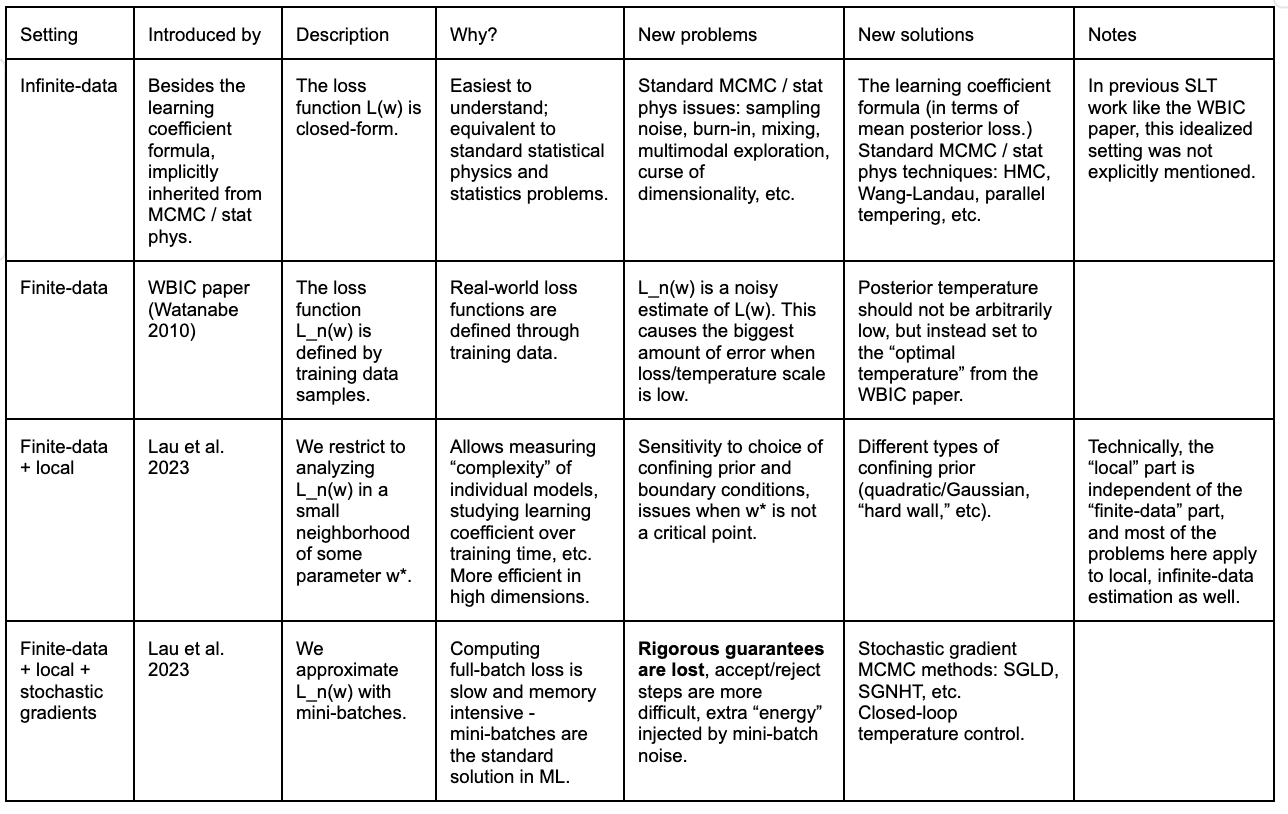

